# Investigate outlier removal

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import hvplot.xarray
from tqdm import tqdm
from dask.distributed import Client
import odlintake
from ooi_hydrophone_cloud import utils
from ni_tools import calculate, inversion
import xrsignal

import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41541,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:44399,Total threads: 4
Dashboard: http://127.0.0.1:46379/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:32873,


In [4]:
fn = '/datadrive/NCCFs/1hr_20150101_20230101_ec_cc_fcs_1_90.nc'
NCCFs = xr.open_dataarray(fn)

time_coord = pd.date_range(pd.Timestamp('2015-01-01'), pd.Timestamp('2022-12-31 t23:59:59.999'), freq='1H')
NCCFs = NCCFs.assign_coords({'time':time_coord})

NCCFs = NCCFs.chunk({'time':100, 'delay':11999})

In [5]:
energy = (NCCFs*NCCFs).mean('delay')
energy_norm = (energy/energy.std()).compute()

#### plot energy norm distribution

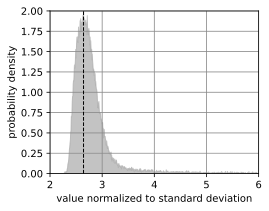

In [20]:
fig = plt.figure(figsize=(3.75,3))
ax = plt.gca()

# Create the histogram
n, bins = np.histogram(energy_norm, bins=np.linspace(0,6,1000), density=True)

# Get the bin widths
bin_width = bins[1] - bins[0]

# Calculate the bin heights
bin_heights = n * bin_width

# Set the color for the shaded area
color = '#AAAAAA'

# Create the shaded area
plt.fill_between(bins[:-1], 0, n, color=color, alpha=0.7)

plt.xlim([2,6])
plt.ylim([0,2])

plt.grid(color='#888888')

plt.ylabel('probability density')
plt.xlabel('value normalized to standard deviation')

ylims = ax.get_ylim()

plt.plot([bins[np.argmax(n)], bins[np.argmax(n)]], ylims, '--k', linewidth=1)
plt.ylim(ylims)

fig.savefig('figures/outlier_removal.svg')

### compute NCCFs for different outlier thresholds

In [5]:
thresholds = ['2.0', '2.2', '2.4', '2.6', '2.8', '3.0', '3.2', '3.4', '3.6', '3.8', '4.0', '4.2', '4.4', '4.6', '4.8', '5.0']

NCCFs_or = {}
for threshold in thresholds:
    NCCFs_or[threshold] = NCCFs.where(energy_norm <= float(threshold), np.nan)
NCCFs_or = xr.Dataset(NCCFs_or)

In [13]:
NCCFs_or_201 = NCCFs_or.rolling(time=201, center=True, min_periods=100).mean()
s1b0A = NCCFs_or_201.sel({'delay':slice(-3.5, -2.5)})

In [14]:
fn = '/datadrive/NCCFs/outlier_removal/s1b0A_201hrs.nc'
s1b0A.to_netcdf(fn)

### calculate arrival times for different thresholds

In [6]:
fn = '/datadrive/NCCFs/outlier_removal/s1b0A_201hrs.nc'
s1b0A = xr.open_dataset(fn).chunk({'time':5000}).load()

In [18]:
arrival_times = -1*inversion.calculate_peak_arrival_time(s1b0A.differentiate('delay'), dim='delay', )

##### plot different arrival times

In [ ]:
arrival_times['3.0'].hvplot(label='3.0') * arrival_times['3.2'].hvplot(label='3.2')

## Calculate RMSE from simulation

In [34]:
fn = '/datadrive/simulation/caldera_inversion_timeseries_HYCOM2.nc'
tdgf = xr.open_dataarray(fn).sel({'time':slice(2.5, 3.5)})
at_sim = inversion.calculate_peak_arrival_time(tdgf, dim='time')

# resample to be 201 hour average arrival time
time_coord = pd.date_range(pd.Timestamp('2015-01-01'), pd.Timestamp('2022-12-31 T23:59:59.999'), freq='1H')
at_sim_1hr = at_sim.interp({'date':time_coord}, method='cubic')
at_sim_201hr = at_sim_1hr.rolling(date=201, center=True).mean()

# resample to match no nan time coord of estimated arrival time
at_sim_201hr_rs = at_sim_201hr.interp(date=arrival_times.time.values, method='linear')
at_sim_201hr_rs = at_sim_201hr_rs.rename({'date':'time'})

In [35]:
rmse = []
data_percent = []
for key in arrival_times.keys():
    rmse.append(float(np.sqrt(((arrival_times[key] - at_sim_201hr_rs)**2).mean())))
    data_percent.append(float((~np.isnan(s1b0A[key][:,0])).sum()/s1b0A[key].sizes['time']))

In [36]:
thresholds = np.array(list(arrival_times.keys())).astype(float)

## generate figures

### no differentiation

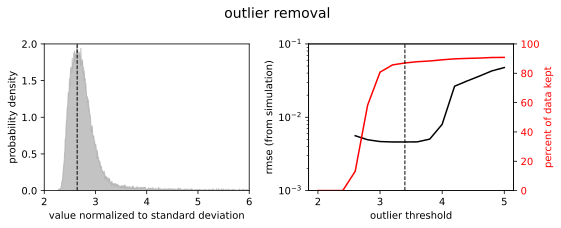

In [47]:
sns.color_palette("hls", 2)

# Create the figure and the first subplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(8,3.2))
fig.suptitle('outlier removal', fontsize=14)

# Plot the first dataset using the first y-axis
color1 = 'k'
ax2.set_xlabel('outlier threshold')
ax2.set_ylabel('rmse (from simulation)', color=color1)
ax2.set_yscale('log')
ax2.set_ylim([1e-3, 1e-1])
ax2.plot(thresholds, rmse, color=color1)
ax2.tick_params(axis='y', labelcolor=color1)

# Create the second subplot sharing the x-axis with the first subplot
ax2_2 = ax2.twinx()

# Plot the second dataset using the second y-axis
color2 = 'r'
ax2_2.set_ylabel('percent of data kept', color=color2)
ax2_2.plot(thresholds, np.array(data_percent)*100, color=color2)
ax2_2.tick_params(axis='y', labelcolor=color2)


ax2_2.plot([3.4, 3.4], [0,100], '--k', linewidth=1)
ax2_2.set_ylim([0,100])


plt.sca(ax1)
# Create the histogram
n, bins = np.histogram(energy_norm, bins=np.linspace(0,6,1000), density=True)

# Get the bin widths
bin_width = bins[1] - bins[0]

# Calculate the bin heights
bin_heights = n * bin_width

# Set the color for the shaded area
color = '#AAAAAA'

# Create the shaded area
plt.fill_between(bins[:-1], 0, n, color=color, alpha=0.7)

plt.xlim([2,6])
plt.ylim([0,2])

#plt.grid(color='#888888')

plt.ylabel('probability density')
plt.xlabel('value normalized to standard deviation')

ylims = ax1.get_ylim()

plt.plot([bins[np.argmax(n)], bins[np.argmax(n)]], ylims, '--k', linewidth=1)
plt.ylim(ylims)
plt.tight_layout()

fig.savefig('figures/outlier_removal.svg')

### with differentiation

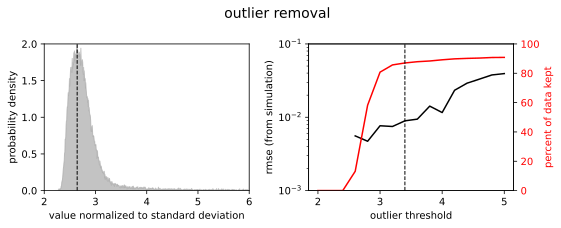

In [37]:
sns.color_palette("hls", 2)

# Create the figure and the first subplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(8,3.2))
fig.suptitle('outlier removal', fontsize=14)

# Plot the first dataset using the first y-axis
color1 = 'k'
ax2.set_xlabel('outlier threshold')
ax2.set_ylabel('rmse (from simulation)', color=color1)
ax2.set_yscale('log')
ax2.set_ylim([1e-3, 1e-1])
ax2.plot(thresholds, rmse, color=color1)
ax2.tick_params(axis='y', labelcolor=color1)

# Create the second subplot sharing the x-axis with the first subplot
ax2_2 = ax2.twinx()

# Plot the second dataset using the second y-axis
color2 = 'r'
ax2_2.set_ylabel('percent of data kept', color=color2)
ax2_2.plot(thresholds, np.array(data_percent)*100, color=color2)
ax2_2.tick_params(axis='y', labelcolor=color2)


ax2_2.plot([3.4, 3.4], [0,100], '--k', linewidth=1)
ax2_2.set_ylim([0,100])


plt.sca(ax1)
# Create the histogram
n, bins = np.histogram(energy_norm, bins=np.linspace(0,6,1000), density=True)

# Get the bin widths
bin_width = bins[1] - bins[0]

# Calculate the bin heights
bin_heights = n * bin_width

# Set the color for the shaded area
color = '#AAAAAA'

# Create the shaded area
plt.fill_between(bins[:-1], 0, n, color=color, alpha=0.7)

plt.xlim([2,6])
plt.ylim([0,2])

#plt.grid(color='#888888')

plt.ylabel('probability density')
plt.xlabel('value normalized to standard deviation')

ylims = ax1.get_ylim()

plt.plot([bins[np.argmax(n)], bins[np.argmax(n)]], ylims, '--k', linewidth=1)
plt.ylim(ylims)
plt.tight_layout()

#fig.savefig('figures/outlier_removal.svg')

### further exploration

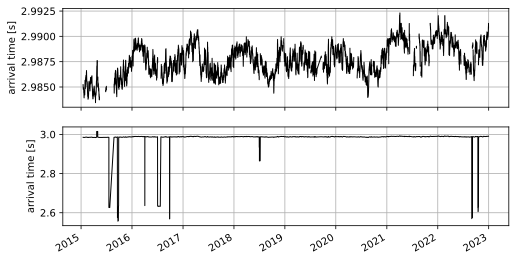

In [102]:
fig = plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
arrival_times['3.4'].plot(c='k', linewidth=1)
plt.grid()
plt.ylabel('arrival time [s]')
plt.xlabel('')
plt.gca().set_xticklabels('')

plt.subplot(2,1,2)
arrival_times['5.0'].plot(c='k', linewidth=1)
plt.grid()
plt.ylabel('arrival time [s]')
plt.xlabel('')

fig.savefig('figures/outlier_removal_ts.svg')

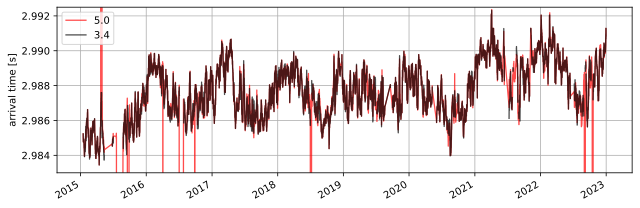

In [11]:
sns.set_palette('hls', 2)
fig = plt.figure(figsize=(9,3))


arrival_times['5.0'].plot(label='5.0', linewidth=1.3, alpha=0.7, c='r')
arrival_times['3.4'].plot(label='3.4', linewidth=1.3, alpha=0.7, c='k')

plt.grid()
plt.ylabel('arrival time [s]')
plt.xlabel('')

plt.ylim([2.983, 2.9925])
plt.legend(loc='upper left')

plt.tight_layout()

fig.savefig('figures/outlier_removal_ts2.svg')

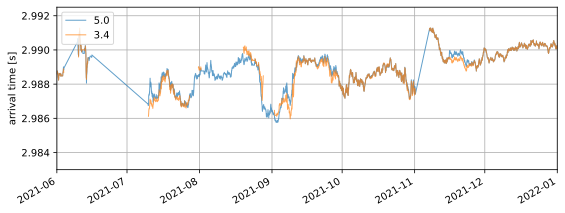

In [14]:
fig = plt.figure(figsize=(9,3))


arrival_times['5.0'].plot(label='5.0', linewidth=1, alpha=0.7, c='r')
arrival_times['3.4'].plot(label='3.4', linewidth=1, alpha=0.7, c='k')

plt.grid()
plt.ylabel('arrival time [s]')
plt.xlabel('')

plt.ylim([2.983, 2.9925])
plt.legend(loc='upper left')

plt.xlim([pd.Timestamp('2021-06-01'), pd.Timestamp('2022-01-01')])
fig.savefig('figures/outlier_removal_ts3.svg')

In [34]:
NCCFs_or_slice = NCCFs_or.sel({'time':slice(pd.Timestamp('2021-07-01'), pd.Timestamp('2021-10-01')), 'delay':slice(-5,5)})[['3.4','5.0']].compute()

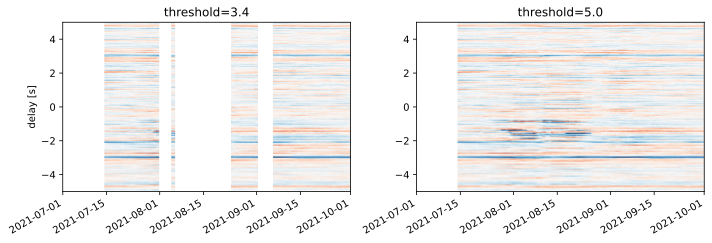

In [48]:
fig = plt.figure(figsize=(10,3.5))

plt.subplot(1,2,1)
NCCFs_or_slice['3.4'].rolling(time=201, min_periods=100).mean().plot(x='time', rasterized=True, vmax=0.002, vmin=-0.002, add_colorbar=False, cmap='RdBu')
plt.ylabel('delay [s]')
plt.xlabel('')
plt.title('threshold=3.4')

plt.subplot(1,2,2)
NCCFs_or_slice['5.0'].rolling(time=201, min_periods=100).mean().plot(x='time', rasterized=True, vmax=0.002, vmin=-0.002, add_colorbar=False, cmap='RdBu')
plt.ylabel('')
plt.xlabel('')
plt.title('threshold=5.0')

plt.tight_layout()
fig.savefig('figures/outlier_removal_NCCFs.svg', dpi=300)